<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%205/Google%20Colab/Tugas_Week_5_PyTorch_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

# Preprocessing Data

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv')

In [3]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# ==== Hyperparameter ====
epochs = 5
num_words = 15000
maxlen = 200
batch_size = 256
embed_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15

In [8]:
# ==== Tentukan kolom yang digunakan ====
review_col = 'Review Text'
rating_col = 'Rating'

# ==== Cek dan isi NaN ====
data[review_col] = data[review_col].fillna("").astype(str)

# ==== Preprocessing Teks ====
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)     # Hapus tanda baca
        text = re.sub(r'\d+', '', text)         # Hapus angka
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w not in stop_words])
    else:
        return ""

data['processed_review'] = data[review_col].apply(preprocess_text)

In [9]:
# ==== Labeling ====
rating_threshold = 3
data['sentiment'] = (data[rating_col] > rating_threshold).astype(int)

# ==== Buat Vocabulary ====
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab[''] = 0
    return vocab

vocabulary = build_vocab(data['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15000


In [10]:
# ==== Convert teks ke sequence ====
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # 0 untuk OOV dan padding
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    else:
        return sequence + [0] * (maxlen - len(sequence))

data['sequence'] = data['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

In [11]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,processed_review,sentiment,sequence
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable,1,"[170, 417, 768, 536, 24, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happened find store im ...,1,"[2, 1, 1506, 47, 1141, 144, 56, 9, 220, 710, 3..."
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hopes dress really wanted work initially ...,0,"[125, 929, 1, 15, 119, 51, 983, 16, 43, 13, 15..."
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ev...,1,"[2, 2, 2, 496, 194, 1131, 646, 221, 111, 7, 58..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering due adjustable front tie perf...,1,"[37, 20, 374, 1011, 93, 364, 18, 35, 7, 185, 1..."


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              23486 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
 11  processed_review         23486 non-null  object
 12  sentiment                23486 non-null  int64 
 13  sequence                 23486 non-null  object
dtypes: int64(7), object(7)
memory usage: 2

In [13]:
# ==== Split Dataset ====
X = np.array(data['sequence'].tolist())
y = np.array(data['sentiment'].tolist())

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# RNN Model

In [15]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers,
                          batch_first=True,
                          nonlinearity='tanh',
                          dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)  # (batch, seq, hidden)
        x = torch.max(rnn_out, dim=1).values  # Global Max Pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
model_rnn = RNNModel(vocab_size, embed_dim, hidden_dim, num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)

In [17]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc


In [18]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds


In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_rnn, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_rnn = eval_data(model_rnn, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Training: 100%|██████████| 74/74 [03:29<00:00,  2.83s/it, loss=0.391]



Epoch 1 — Train Loss: 0.4991, Train Acc: 0.7767, Val Loss: 0.4125, Val Acc: 0.8184


Training: 100%|██████████| 74/74 [03:51<00:00,  3.12s/it, loss=0.292]



Epoch 2 — Train Loss: 0.3703, Train Acc: 0.8360, Val Loss: 0.3613, Val Acc: 0.8436


Training: 100%|██████████| 74/74 [04:14<00:00,  3.43s/it, loss=0.441]



Epoch 3 — Train Loss: 0.3126, Train Acc: 0.8647, Val Loss: 0.3370, Val Acc: 0.8567


Training: 100%|██████████| 74/74 [04:11<00:00,  3.40s/it, loss=0.295]



Epoch 4 — Train Loss: 0.2834, Train Acc: 0.8823, Val Loss: 0.3314, Val Acc: 0.8621


Training: 100%|██████████| 74/74 [04:29<00:00,  3.64s/it, loss=0.289]



Epoch 5 — Train Loss: 0.2463, Train Acc: 0.9003, Val Loss: 0.3425, Val Acc: 0.8580


In [20]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")


Accuracy: 0.8580
Precision: 0.8556
Recall: 0.8580
F1-score: 0.8567


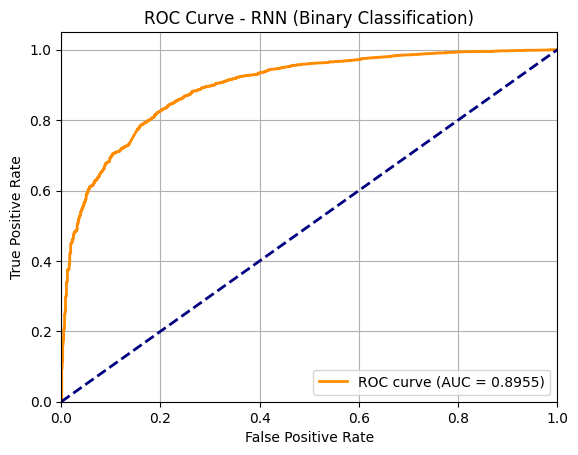

In [21]:
y_prob_rnn = []
y_true = []

model_rnn.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_rnn(inputs)
        y_prob_rnn.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

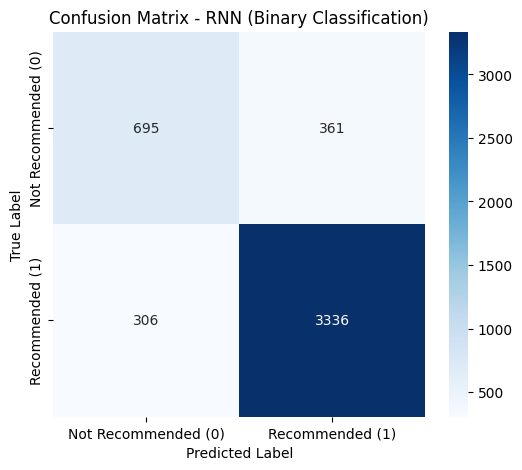

In [22]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

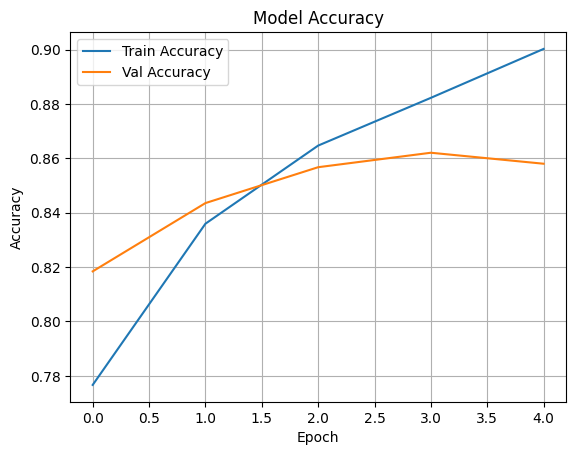

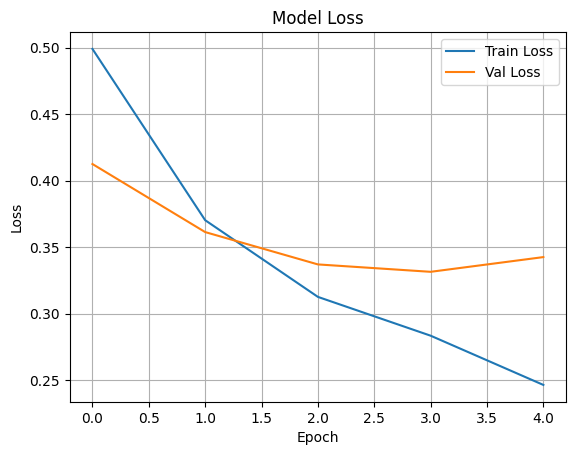

In [23]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis RNN Model

## 📊 Evaluasi Model RNN PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 0.8580
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0.8556  
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0.8580
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0.8567
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.8955
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi sekitar 85.8%** dan **AUC Score sangat tinggi** (0.8955) menandakan model mampu membedakan antar kelas dengan baik. F1 score juga cukup tinggi, menandakan keseimbangan antara precision dan recall.

# LSTM Model

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True,
                            dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = torch.max(lstm_out, dim=1).values
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [25]:
model_lstm = LSTMModel(vocab_size, embed_dim, hidden_dim, num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

In [26]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc

In [27]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds


In [28]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_lstm, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_lstm = eval_data(model_lstm, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Training: 100%|██████████| 74/74 [10:32<00:00,  8.55s/it, loss=0.328]



Epoch 1 — Train Loss: 0.4949, Train Acc: 0.7722, Val Loss: 0.4004, Val Acc: 0.8248


Training: 100%|██████████| 74/74 [10:18<00:00,  8.36s/it, loss=0.319]



Epoch 2 — Train Loss: 0.3532, Train Acc: 0.8480, Val Loss: 0.3482, Val Acc: 0.8521


Training: 100%|██████████| 74/74 [10:19<00:00,  8.37s/it, loss=0.283]



Epoch 3 — Train Loss: 0.2982, Train Acc: 0.8784, Val Loss: 0.3328, Val Acc: 0.8593


Training: 100%|██████████| 74/74 [10:21<00:00,  8.40s/it, loss=0.21]



Epoch 4 — Train Loss: 0.2664, Train Acc: 0.8944, Val Loss: 0.3564, Val Acc: 0.8495


Training: 100%|██████████| 74/74 [10:22<00:00,  8.41s/it, loss=0.301]



Epoch 5 — Train Loss: 0.2364, Train Acc: 0.9094, Val Loss: 0.3216, Val Acc: 0.8661


In [29]:
# Evaluasi
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

# Output
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

Accuracy: 0.8661
Precision: 0.8926
Recall: 0.9404
F1-score: 0.9159


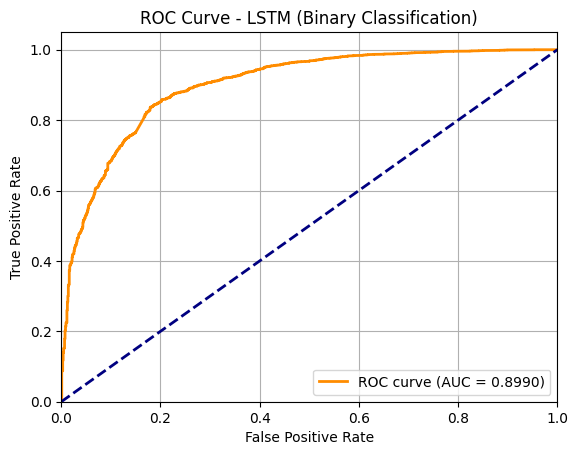

In [42]:
y_prob_lstm = []
y_true = []

model_lstm.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm(inputs)
        y_prob_lstm.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())


# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

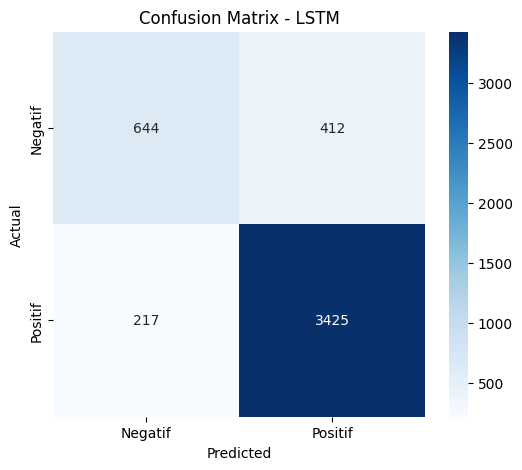

In [31]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

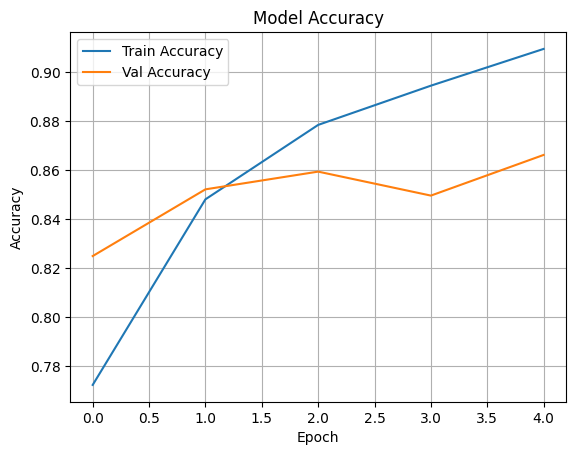

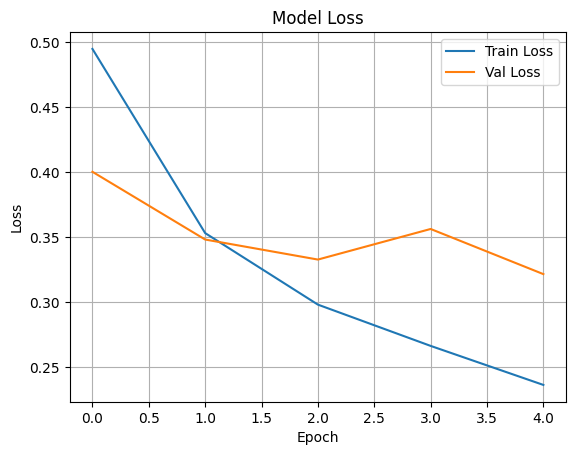

In [32]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis LSTM Model

## 📊 Evaluasi Model LSTM PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 0.8661
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0.8926  
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0.9404
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0.9159
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.8990
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi sekitar 86.6%** dan **AUC Score sangat tinggi** (0.8990) menandakan model mampu membedakan antar kelas dengan baik. F1 score juga cukup tinggi, menandakan keseimbangan antara precision dan recall.

# GRU Model

In [33]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers,
                          batch_first=True,
                          dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        x = torch.max(gru_out, dim=1).values
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [34]:
model_gru = GRUModel(vocab_size, embed_dim, hidden_dim, num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=1e-3)

In [35]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc

In [36]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds


In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_gru, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_gru = eval_data(model_gru, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Training: 100%|██████████| 74/74 [08:00<00:00,  6.50s/it, loss=0.357]



Epoch 1 — Train Loss: 0.4521, Train Acc: 0.7937, Val Loss: 0.3795, Val Acc: 0.8352


Training: 100%|██████████| 74/74 [07:47<00:00,  6.32s/it, loss=0.317]



Epoch 2 — Train Loss: 0.3355, Train Acc: 0.8556, Val Loss: 0.3379, Val Acc: 0.8555


Training: 100%|██████████| 74/74 [07:45<00:00,  6.28s/it, loss=0.386]



Epoch 3 — Train Loss: 0.2825, Train Acc: 0.8817, Val Loss: 0.3213, Val Acc: 0.8610


Training: 100%|██████████| 74/74 [07:42<00:00,  6.26s/it, loss=0.209]



Epoch 4 — Train Loss: 0.2489, Train Acc: 0.9000, Val Loss: 0.3320, Val Acc: 0.8727


Training: 100%|██████████| 74/74 [07:45<00:00,  6.28s/it, loss=0.219]



Epoch 5 — Train Loss: 0.2125, Train Acc: 0.9184, Val Loss: 0.3162, Val Acc: 0.8714


In [38]:
# Evaluasi
accuracy_gru = accuracy_score(y_test, y_pred_gru)
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

# Output
print(f"Accuracy: {accuracy_gru:.4f}")
print(f"Precision: {precision_gru:.4f}")
print(f"Recall: {recall_gru:.4f}")
print(f"F1-score: {f1_gru:.4f}")

Accuracy: 0.8714
Precision: 0.9143
Recall: 0.9204
F1-score: 0.9174


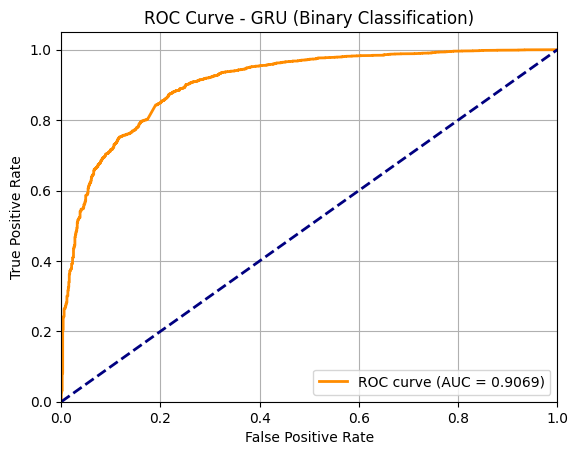

In [39]:
y_prob_gru = []
y_true = []

model_gru.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_gru(inputs)
        y_prob_gru.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_gru)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

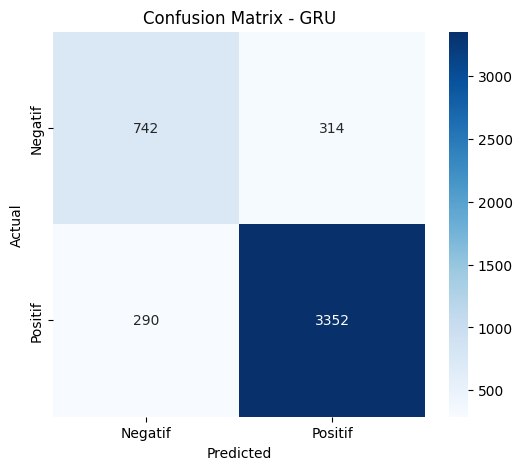

In [40]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU')
plt.show()

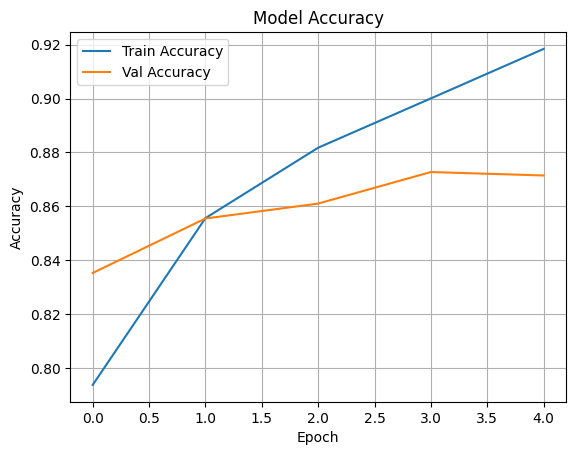

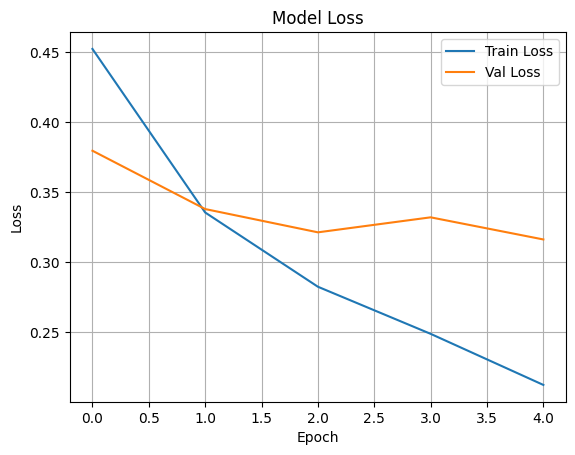

In [41]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis GRU Model

## 📊 Evaluasi Model GRU PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 0.8714
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0.9143
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0.9204
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0.9174
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.9069
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi sekitar 87.1%** dan **AUC Score sangat tinggi** (0.9069) menandakan model mampu membedakan antar kelas dengan baik. F1 score juga cukup tinggi, menandakan keseimbangan antara precision dan recall.